# 1. Setup

### 1.1 Install Dependencies

In [1]:
# %pip install tensorflow[and-cuda]

In [2]:
# %pip install tensorflow==2.10.0 

In [3]:
# %pip install matplotlib

In [4]:
# %pip install opencv-python

In [5]:
#tensorflow-gpu==2.15.0 opencv-python matplotlib

In [6]:
# %pip install tensorflow-gpu==2.10.0

### Import Dependencies 

In [3]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# import tensorflow dependencies -Funtcional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten 
import tensorflow as tf

Using TensorFlow functional API simply because it is alot more flexable than the sequencal api, in terms of hardcore deep learning models 
I will also be building a Siammese Neural Network that way we can pass in two immmages at a time, and the nueral netwrok will measure the similarity between them. The network will be trained on how similar they are (1=similar/verified 0=not similar/not verified)

### 1.3 Set Gpu Growth
We want to limit how much vram tensorflow has access to if not we will run into out of memory errors. 

In [5]:
# Avoid OOM erros by seting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
for gpu in gpus:
    print(gpu)
len(gpus)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


1

### 1.4 Create Folder Structures

Setup paths and create directories 

In [7]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2 Collect Positivies and Anchors


### 2.1 Untar Labelled Faces in the Wild Dataset

negatives will be collected from the labled faces in the wild dataset from https://vis-www.cs.umass.edu/lfw/
it is a compressed tar dataset so we must uncompress it before we attempt to use the dataset.

In [12]:
# !tar -xf lfw.tgz

In [13]:
# move the LFW images to the data/negative folder
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

### 2.2 Collect Positives and Anchor Classes

access the webcam using opencv to collect the postives 

In [8]:
# # show avialble cameras indexes
# def get_available_cameras():
#     available_cameras = []
#     # Check for 5 cameras 
#     for i in range(5):
#         cap = cv2.VideoCapture(i)
#         if cap.isOpened():
#             available_cameras.append(i)
#             cap.release()
#     return available_cameras

# cameras = get_available_cameras()
# if cameras:
#     print("Available Cameras:", cameras)
# else:
#     print("No cameras found.")

Available Cameras: [0, 1, 2]


In [9]:
# import uuid library to generate unique image names
import uuid

In [18]:
cap = cv2.VideoCapture(0)                   # connection to webcam
if not cap.isOpened():
    print("Cannot open camera")
    exit()

while cap.isOpened():                       # while webcam is running
    ret, frame = cap.read()                 # read frame
    # crop image
    frame = frame[170:170+250,400:400+250, :]
    
    # collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) # generate unique file path
        cv2.imwrite(imgname, frame)        # save image
    # collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())) # generate unique file path
        cv2.imwrite(imgname, frame)        # save image

    cv2.imshow('Image Collection', frame)   # show frameq

    if cv2.waitKey(1) & 0xFF == ord('q'):   # if 'q' is pressed, then stop
        break
    
cap.release()                               # release webcam
cv2.destroyAllWindows()                     # close the image show frame

In [17]:
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     print("Cannot open camera")
#     exit()

# while cap.isOpened():
#     ret, frame = cap.read()

#     # Resize the frame for faster processing (optional)
#     frame = cv2.resize(frame, (640, 480))

#     # Convert the frame to grayscale for face detection
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # Detect faces in the frame
#     faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

#     if len(faces) > 0:
#         # Take the first detected face (assuming only one person in front of the camera)
#         x, y, w, h = faces[0]

#         # Crop the face region
#         face_roi = frame[y:y + h, x:x + w]

#         # Resize the face region to 250x250 pixels
#         resized_face = cv2.resize(face_roi, (250, 250))

#         # Display the resized face
#         cv2.imshow('Resized Face', resized_face)

#         # Collect anchors
#         if cv2.waitKey(1) & 0xFF == ord('a'):
#             imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#             cv2.imwrite(imgname, resized_face)

#         # Collect positives
#         if cv2.waitKey(1) & 0xFF == ord('p'):
#             imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#             cv2.imwrite(imgname, resized_face)

#     cv2.imshow('Original Frame', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

# 3 Load and Process Images

### 3.1 Get image Directories

In [19]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [20]:
dir_test = anchor.as_numpy_iterator()

In [21]:
dir_test.next()

b'data\\anchor\\d5e6020c-b700-11ee-9ead-f8ac65ab46be.jpg'

### 3.2 Preprocessing - Scale and Resize

read in an image from its file path, load it then resize the image to be 100x100x3. We are doing this just to follow along with the paper about siamese neural network

In [25]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img / 255.0
    return img

In [26]:
img = preprocess('data\\anchor\\d5e6020c-b700-11ee-9ead-f8ac65ab46be.jpg')

In [28]:
img.numpy().max()

0.95710784

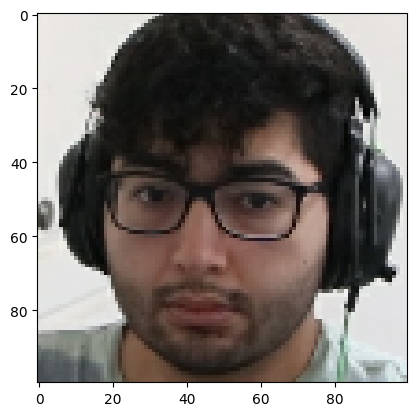

In [29]:
plt.imshow(img)

### 3.3 Create Labelled Datasset

In [30]:
postives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = postives.concatenate(negatives)

In [31]:
samples = data.as_numpy_iterator()

In [32]:
exampple = samples.next()

In [33]:
exampple

(b'data\\anchor\\d69a3c7e-b700-11ee-a0db-f8ac65ab46be.jpg',
 b'data\\positive\\2276cd64-b701-11ee-b9c7-f8ac65ab46be.jpg',
 1.0)

In [34]:
len(exampple)

3

### 3.4 Build Train and  Test Partition

In [35]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [36]:
res = preprocess_twin(*exampple)


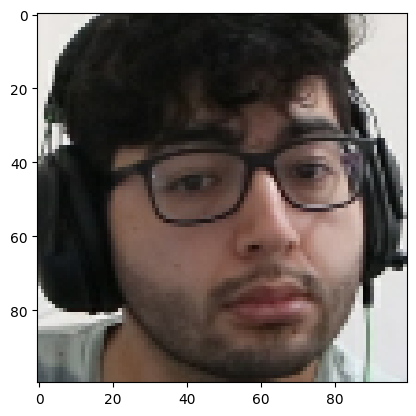

In [37]:
plt.imshow(res[1])


In [38]:
res[2]


1.0

In [39]:
# Build data loader pipeline
# data = positive.map(preprocess)
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)


In [40]:
# Training Partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [41]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4 Model Engineering

### 4.1 Build Embedding Layer

In [42]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First Block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:
embedding = make_embedding()

In [44]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### 4.2 Build Distance Layer

In [45]:
# Siamese L1 Distance Class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwards):
        super().__init__()
    
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [46]:
l1 = L1Dist()

In [47]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

### 4.3 Make Siamese Model

In [49]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [50]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [51]:
siamese_layer = L1Dist()

In [52]:
distances = siamese_layer(inp_embedding, val_embedding)

In [53]:
classifier = Dense(1, activation='sigmoid')(distances)

In [54]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [55]:
siamese_network = Model(inputs=[input_image, validation_image], outputs= classifier, name ='SiameseNetwork')

In [56]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [57]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image input in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs= classifier, name ='SiameseNetwork') 

In [58]:
siamese_model = make_siamese_model()

In [59]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

### 5.1 Setup Loss and Optimizer

In [60]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [61]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### 5.2 Establish Checkpoints 

In [62]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.3 Build Train Step Function

In [63]:
test_batch = train_data.as_numpy_iterator()

In [64]:
batch_1 = test_batch.next()

In [65]:
X = batch_1[:2]

In [66]:
y =batch_1[2]

In [67]:
y

array([0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.],
      dtype=float32)

In [68]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
      floating-point value which either represents a
      [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
      when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
      `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
      loss=tf.keras.losses

In [69]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

### 5.4 Build Training Loop

In [70]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### 5.5 Train the model

In [71]:
EPOCHS = 50

In [72]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 21s 379ms/step

 Epoch 2/50
27/27 [==============================] - 9s 353ms/step

 Epoch 3/50
27/27 [==============================] - 9s 344ms/step

 Epoch 4/50
27/27 [==============================] - 9s 343ms/step

 Epoch 5/50
27/27 [==============================] - 9s 343ms/step

 Epoch 6/50
27/27 [==============================] - 9s 339ms/step

 Epoch 7/50
27/27 [==============================] - 9s 338ms/step

 Epoch 8/50
27/27 [==============================] - 9s 340ms/step

 Epoch 9/50
27/27 [==============================] - 9s 339ms/step

 Epoch 10/50
27/27 [==============================] - 9s 340ms/step

 Epoch 11/50
27/27 [==============================] - 9s 338ms/step

 Epoch 12/50
27/27 [==============================] - 9s 340ms/step

 Epoch 13/50
27/27 [=====

# 6. Evaluation Mode

### 6.1 Import Metrics

In [73]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### 6.2 Make Predictions

In [74]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [75]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 469ms/step


array([[5.3856016e-05],
       [9.9959654e-01],
       [1.0000000e+00],
       [9.9999952e-01],
       [1.0000000e+00],
       [9.9999940e-01],
       [3.1831277e-10],
       [3.4686251e-13],
       [9.9969041e-01],
       [6.0148934e-12],
       [3.4028627e-11],
       [4.2925546e-12],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.4614824e-12],
       [9.9969244e-01]], dtype=float32)

In [76]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]

In [77]:
y_true

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

### 6.3 Calculate Metrics

In [78]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [79]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

### 6.4 Viz Results

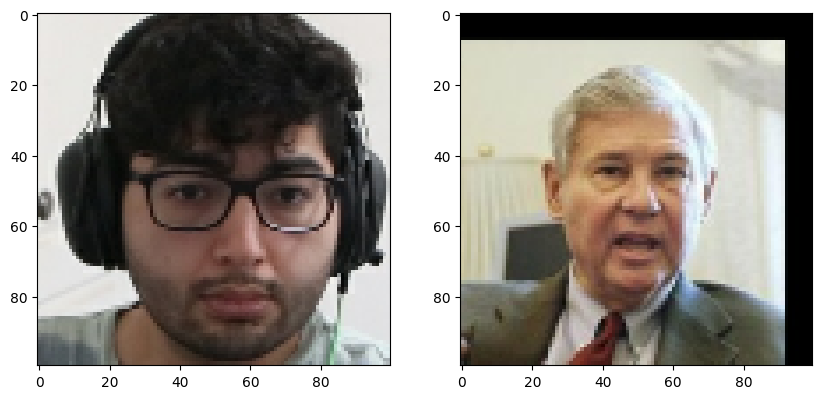

In [80]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save the model

In [81]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [82]:
L1Dist

__main__.L1Dist

In [83]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [84]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 127ms/step


array([[5.3856016e-05],
       [9.9959654e-01],
       [1.0000000e+00],
       [9.9999952e-01],
       [1.0000000e+00],
       [9.9999940e-01],
       [3.1831277e-10],
       [3.4686251e-13],
       [9.9969041e-01],
       [6.0148934e-12],
       [3.4028627e-11],
       [4.2925546e-12],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.4614824e-12],
       [9.9969244e-01]], dtype=float32)

In [85]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

### 8.1 Verification Function

Access our webcam using opencv as the input image, compare it to a number our our positve samples which were already taken. Every full verification cycle will be 50 cycles of prediction. this way we can have a higher chance to accurately verifiy the input image. 

We also want to establish a threshold so if the input image is 80% similar to our positive samples then it will be sufficient. (The 80% iis just an example the threshold is tunable)
There will be two thresholds the first will be established by how many input frames pass from the 50 cycles (if 30 out of the 50 pass then 30/50 = 1st threshold) 

In [86]:
# application_data\verification_images

In [87]:
os.listdir(os.path.join('application_data', 'verification_images'))

['012f6581-b0cd-11ee-927a-f8ac65ab46bd.jpg',
 '0161f26f-b0cd-11ee-800d-f8ac65ab46bd.jpg',
 '5ae48488-b0cc-11ee-ac39-f8ac65ab46bd.jpg',
 '5ae9668c-b0cc-11ee-a929-f8ac65ab46bd.jpg',
 '5aee2190-b0cc-11ee-a335-f8ac65ab46bd.jpg',
 '5af2f13b-b0cc-11ee-b959-f8ac65ab46bd.jpg',
 '5af7d346-b0cc-11ee-a559-f8ac65ab46bd.jpg',
 '5afcb550-b0cc-11ee-a587-f8ac65ab46bd.jpg',
 '5b01972d-b0cc-11ee-8517-f8ac65ab46bd.jpg',
 '5b0679bd-b0cc-11ee-90ad-f8ac65ab46bd.jpg',
 '5b12a2ce-b0cc-11ee-9ef5-f8ac65ab46bd.jpg',
 '5b1784de-b0cc-11ee-8d78-f8ac65ab46bd.jpg',
 '5b1c3b83-b0cc-11ee-bcc6-f8ac65ab46bd.jpg',
 '5b21baab-b0cc-11ee-b445-f8ac65ab46bd.jpg',
 '5b346307-b0cc-11ee-9674-f8ac65ab46bd.jpg',
 '5b392a95-b0cc-11ee-9216-f8ac65ab46bd.jpg',
 '5b4140c5-b0cc-11ee-afb8-f8ac65ab46bd.jpg',
 '5b4fcf65-b0cc-11ee-a976-f8ac65ab46bd.jpg',
 '5b5cc932-b0cc-11ee-b4b5-f8ac65ab46bd.jpg',
 '5b615d3c-b0cc-11ee-b7b9-f8ac65ab46bd.jpg',
 '5b663f7a-b0cc-11ee-a905-f8ac65ab46bd.jpg',
 '5b7228be-b0cc-11ee-97b0-f8ac65ab46bd.jpg',
 '5b770a7c

In [88]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [89]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\012f6581-b0cd-11ee-927a-f8ac65ab46bd.jpg
application_data\verification_images\0161f26f-b0cd-11ee-800d-f8ac65ab46bd.jpg
application_data\verification_images\5ae48488-b0cc-11ee-ac39-f8ac65ab46bd.jpg
application_data\verification_images\5ae9668c-b0cc-11ee-a929-f8ac65ab46bd.jpg
application_data\verification_images\5aee2190-b0cc-11ee-a335-f8ac65ab46bd.jpg
application_data\verification_images\5af2f13b-b0cc-11ee-b959-f8ac65ab46bd.jpg
application_data\verification_images\5af7d346-b0cc-11ee-a559-f8ac65ab46bd.jpg
application_data\verification_images\5afcb550-b0cc-11ee-a587-f8ac65ab46bd.jpg
application_data\verification_images\5b01972d-b0cc-11ee-8517-f8ac65ab46bd.jpg
application_data\verification_images\5b0679bd-b0cc-11ee-90ad-f8ac65ab46bd.jpg
application_data\verification_images\5b12a2ce-b0cc-11ee-9ef5-f8ac65ab46bd.jpg
application_data\verification_images\5b1784de-b0cc-11ee-8d78-f8ac65ab46bd.jpg
application_data\verification_images\5b1c3b83-b0cc-11ee-bcc6-f8a

In [90]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 OpenCV Real Time Verification 

In [102]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[170:170+250,400:400+250,:]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 25ms/step
False


In [103]:
np.squeeze(results) > 0.9

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [104]:
np.sum(np.squeeze(results) > 0.9)

0